In [1]:
import utils.cs_vqe_tools as c_tools
import utils.qonversion_tools as qonvert
import utils.bit_tools as bit
import utils.circuit_tools as circ
import utils.linalg_tools as la
import utils.plotting_tools as plot

import cs_vqe_classes.cs_vqe as c
import cs_vqe_classes.eigenstate as eig
import cs_vqe_classes.cs_vqe_circuit as cs_circ

import ast
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from openfermion.linalg import LinearQubitOperator, get_sparse_operator, get_ground_state
import itertools
from statistics import median

from qiskit.circuit.parameter import Parameter
from qiskit.circuit.quantumcircuit import QuantumCircuit, QuantumRegister
from qiskit import QuantumCircuit, BasicAer, execute
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.aqua.components.optimizers import SLSQP, COBYLA
from qiskit.algorithms import VQE
from qiskit import Aer

import cirq

from qiskit.providers.aer import AerError

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/aqua/components/optimizers/optimizer.py:50: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  'qiskit.algorithms.optimizers', 'qiskit-terra')


In [2]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = '3-21g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham_f = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham_f)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
ucc = qonvert.QubitOperator_to_dict(ucc_q, num_qubits)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (1.1324434021069387+0j) [] +
(-0.02581025441481443+0j) [X0 X1 Y2 Y3] +
(-0.01279993478643725+0j) [X0 X1 Y2 Z3 Z4 Y5] +
(-0.02515964583989765+0j) [X0 X1 Y2 Z3 Z4 Z5 Z6 Y7] +
(-0.01279993478643725+0j) [X0 X1 X3 X4] +
(-0.02515964583989765+0j) [X0 X1 X3 Z4 Z5 X6] +
(-0.017114528821774805+0j) [X0 X1 Y4 Y5] +
(-0.0009891049103631455+0j) [X0 X1 Y4 Z5 Z6 Y7] +
(-0.0009891049103631455+0j) [X0 X1 X5 X6] +
(-0.05469856574684963+0j) [X0 X1 Y6 Y7] +
(0.02581025441481443+0j) [X0 Y1 Y2 X3] +
(0.01279993478643725+0j) [X0 Y1 Y2 Z3 Z4 X5] +
(0.02515964583989765+0j) [X0 Y1 Y2 Z3 Z4 Z5 Z6 X7] +
(-0.01279993478643725+0j) [X0 Y1 Y3 X4] +
(-0.02515964583989765+0j) [X0 Y1 Y3 Z4 Z5 X6] +
(0.017114528821774805+0j) [X0 Y1 Y4 X5] +
(0.0009891049103631455+0j) [X0 Y1 Y4 Z5 Z6 X7] +
(-0.0009891049103631455+0j) [X0 Y1 Y5 X6] +
(0.05469856574684963+0j) [X0 Y1 Y6 X7] +
(0.0025779051794105196+0j) [X0 Z1 X2] +
(0.0047661481056806175+0j) [X0 Z1 X2 X3 Z4 X5] +
(-0.009264702923307527+0j) [X0 Z1 X2 X3 Z4 Z5 Z

UCCSD ansatz: 
 0.006478936130102838j [X0 X1 X2 Y3] +
0.006478936130102838j [X0 X1 Y2 X3] +
0.0020562744029710704j [X0 X1 X4 Y5] +
0.0020562744029710704j [X0 X1 Y4 X5] +
0.005083283191416048j [X0 X1 X6 Y7] +
0.005083283191416048j [X0 X1 Y6 X7] +
-0.006478936130102838j [X0 Y1 X2 X3] +
0.006478936130102838j [X0 Y1 Y2 Y3] +
-0.0020562744029710704j [X0 Y1 X4 X5] +
0.0020562744029710704j [X0 Y1 Y4 Y5] +
-0.005083283191416048j [X0 Y1 X6 X7] +
0.005083283191416048j [X0 Y1 Y6 Y7] +
-0.006360390047729467j [X0 Z1 Y2] +
-0.002645411873769119j [X0 Z1 Z2 Z3 Y4] +
0.0009221551709274561j [X0 Z1 Z2 Z3 Z4 Z5 Y6] +
-0.006478936130102838j [Y0 X1 X2 X3] +
0.006478936130102838j [Y0 X1 Y2 Y3] +
-0.0020562744029710704j [Y0 X1 X4 X5] +
0.0020562744029710704j [Y0 X1 Y4 Y5] +
-0.005083283191416048j [Y0 X1 X6 X7] +
0.005083283191416048j [Y0 X1 Y6 Y7] +
-0.006478936130102838j [Y0 Y1 X2 Y3] +
-0.006478936130102838j [Y0 Y1 Y2 X3] +
-0.0020562744029710704j [Y0 Y1 X4 Y5] +
-0.0020562744029710704j [Y0 Y1 Y4 X5] +
-0.0

In [3]:
hamiltonian = qonvert.QubitOperator_to_dict(ham_q, num_qubits)#
terms_noncon = c_tools.greedy_dfs(hamiltonian, 1, criterion='weight')[-1]

q4 not simulated
Simulating 1 out of 8 qubits | VQE result: -3.1386757819124016
q4 not simulated


/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


Simulating 2 out of 8 qubits | VQE result: -3.1423535499978095
q4 not simulated
Simulating 3 out of 8 qubits | VQE result: -3.1420143447332363
q4 not simulated
Simulating 4 out of 8 qubits | VQE result: -3.1414119288655096


/mnt/c/Users/Tim/Jupyter Projects/ContextualSubspaceVQE/utils/plotting_tools.py:102: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ncol=5)


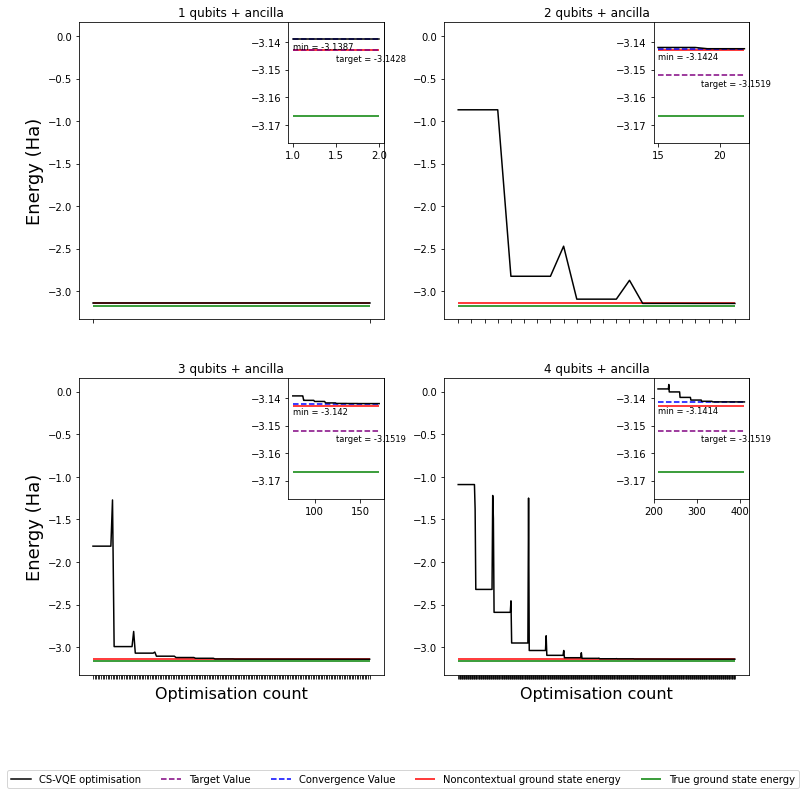

In [4]:
order = [6, 0, 1, 2, 3, 4, 5, 7]

cs_vqe_plot = plot.plot_cs_vqe_convergence(hamiltonian, terms_noncon, ucc, num_qubits, order, 4)

In [5]:
circs = cs_circ.cs_vqe_circuit(hamiltonian, terms_noncon, num_qubits, order)

In [6]:
mol = c.cs_vqe(hamiltonian, terms_noncon,num_qubits)
A = mol.generators(rot=True)[1]

In [7]:
circs.CS_VQE(['IXIXIXIX', 'YYYYIIII', 'IIIIYYYY'], 8, A)

(0.9967723981014137,
 -1.0000000000000002,
 [1, 2, 3, 4],
 [0.9967723981014137,
  0.9967723981014137,
  0.9967723981014135,
  0.9967723981014135])

In [8]:
circs.build_circuit(['IXIXIXIX'], 8).draw()

░ ┌───┐                                         ┌───┐ ░  ░ ┌───┐»
q_0: ──────░─┤ H ├──■───────────────────────────────────■──┤ H ├─░──░─┤ H ├»
           ░ └───┘  │                                   │  └───┘ ░  ░ └───┘»
q_1: ──────░────────┼───────────────────────────────────┼────────░──░──────»
           ░ ┌───┐┌─┴─┐                               ┌─┴─┐┌───┐ ░  ░ ┌───┐»
q_2: ──────░─┤ H ├┤ X ├──■─────────────────────────■──┤ X ├┤ H ├─░──░─┤ H ├»
           ░ └───┘└───┘  │                         │  └───┘└───┘ ░  ░ └───┘»
q_3: ──────░─────────────┼─────────────────────────┼─────────────░──░──────»
     ┌───┐ ░ ┌───┐     ┌─┴─┐                     ┌─┴─┐┌───┐      ░  ░ ┌───┐»
q_4: ┤ X ├─░─┤ H ├─────┤ X ├──■───────────────■──┤ X ├┤ H ├──────░──░─┤ H ├»
     └───┘ ░ └───┘     └───┘  │               │  └───┘└───┘      ░  ░ └───┘»
q_5: ──────░──────────────────┼───────────────┼──────────────────░──░──────»
           ░                ┌─┴─┐┌─────────┐┌─┴─┐                ░  ░      »
q_6: ──────░────────────────┤ X ├┤ RZ(αβγ) ├┤ X ├────────────────░──░──────»
           ░                └───┘└─────────┘└───┘                ░  ░      »
q_7: ──────░─────────────────────────────────────────────────────░──░──────»
           ░                                                     ░  ░      »
q_8: ──────░─────────────────────────────────────────────────────░──░──────»
           ░                                                     ░  ░      »
«                                              ┌───┐ ░                         »
«q_0: ──■───────────────────────────────────■──┤ H ├─░─────────────────────────»
«       │                                   │  └───┘ ░ ┌───┐┌────────────┐     »
«q_1: ──┼───────────────────────────────────┼────────░─┤ X ├┤ RY(3.1014) ├─────»
«     ┌─┴─┐                               ┌─┴─┐┌───┐ ░ └───┘└────────────┘     »
«q_2: ┤ X ├──■─────────────────────────■──┤ X ├┤ H ├─░───■─────────────────────»
«     └───┘  │                         │  └───┘└───┘ ░ ┌─┴─┐                   »
«q_3: ───────┼─────────────────────────┼─────────────░─┤ X ├──────■────────────»
«          ┌─┴─┐                     ┌─┴─┐┌───┐      ░ └───┘    ┌─┴─┐          »
«q_4: ─────┤ X ├──■───────────────■──┤ X ├┤ H ├──────░──────────┤ X ├───────■──»
«          └───┘  │               │  └───┘└───┘      ░          └───┘     ┌─┴─┐»
«q_5: ────────────┼───────────────┼──────────────────░────────────────────┤ X ├»
«               ┌─┴─┐┌─────────┐┌─┴─┐                ░                    └───┘»
«q_6: ──────────┤ X ├┤ RZ(αβγ) ├┤ X ├────────────────░─────────────────────────»
«               └───┘└─────────┘└───┘                ░                         »
«q_7: ───────────────────────────────────────────────░─────────────────────────»
«                                                    ░                         »
«q_8: ───────────────────────────────────────────────░─────────────────────────»
«                                                    ░                         »
«                                           
«q_0: ──────────────────────────────────────
«                                           
«q_1: ───────────■──────────────────────────
«                │                          
«q_2: ───────────┼───────────────────────■──
«                │                     ┌─┴─┐
«q_3: ───────────┼──────────────────■──┤ X ├
«                │                ┌─┴─┐└───┘
«q_4: ───────────┼─────────────■──┤ X ├─────
«                │           ┌─┴─┐└───┘     
«q_5: ──■────────┼────────■──┤ X ├──────────
«     ┌─┴─┐      │      ┌─┴─┐└───┘          
«q_6: ┤ X ├──■───┼───■──┤ X ├───────────────
«     └───┘  │   │   │  └───┘               
«q_7: ───────┼───┼───┼──────────────────────
«          ┌─┴─┐ │ ┌─┴─┐                    
«q_8: ─────┤ X ├─■─┤ X ├─|0>────────────────
«          └───┘   └───┘

In [9]:
from qiskit.quantum_info.operators import Operator, Pauli
# Create an operator
P1 = Operator(Pauli(label='IZZZZZXI'))
P2 = Operator(Pauli(label='IIIIIIZI'))

# Add to a circuit
circ = QuantumCircuit(8)
circ.append(0.618*P1+0.618*P2,[0,1,2,3,4,5,6,7])
circ.draw()

/home/tim/anaconda3/lib/python3.7/site-packages/qiskit/quantum_info/operators/symplectic/pauli.py:187: DeprecationWarning: Initializing Pauli from `Pauli(label=l)` kwarg is deprecated as of version 0.17.0 and will be removed no earlier than 3 months after the release date. Use `Pauli(l)` instead.
  base_z, base_x, base_phase = self._from_label_deprecated(label)


ExtensionError: 'Input matrix is not unitary.'

In [ ]:
print(eig.eigenstate(A, 16, num_qubits).construct())
print(eig.eigenstate(A, 18, num_qubits).construct())

In [ ]:
I_op = openfermion.ops.QubitOperator.identity()
A_op = qonvert.dict_to_QubitOperator(A)
A_array = get_sparse_operator(A_op, n_qubits=8).toarray()

In [ ]:
psi = la.random_complex_vector(2**8)
projector = get_sparse_operator((A_op+I_op)/2, n_qubits=8).toarray()

In [ ]:
psi_sub = np.dot(projector, psi)
psi_conj = np.conjugate(psi_sub)
norm = np.sqrt(np.dot(psi_conj, psi_sub))

In [ ]:
psi_sub = psi_sub/norm
psi_conj = np.conjugate(psi_sub)
np.dot(psi_conj, psi_sub)

In [ ]:
la.expectation(A_op, psi_sub, 8)

In [ ]:
conj_psi = np.conjugate(psi)
conj_psi.dot(psi)

In [ ]:
type(projector)